<h3>Image Bit/Text Conversion</h3>
<p>The following is just playing around with different data types to store information which makes up a 1080p image.</p>
<p>I import an image using Pillow and save its Red-Green-Blue data as a Numpy array, then convert this array into a string of 8-digit numbers (rather than just 9-digit copies of RGB values) to save to a text file as well as a binary file. Then I simply re-read in those two files and convert back into the original numpy array to finally display the image once again.</p>

In [1]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
import struct

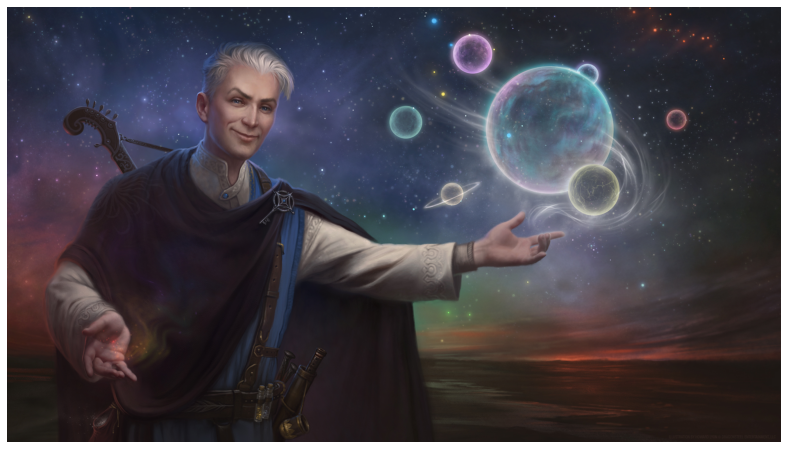

Img: (1080, 1920, 3)


In [2]:
# Import image and display using pyplot
img_rgb_px_array = imread(os.path.join("img_test.jpg"))

#display image using plt
plt.rcParams['figure.figsize'] = [16, 8]
img = plt.imshow(img_rgb_px_array)
plt.axis('off')
plt.show()
# Call image size
print(f'Img: {img_rgb_px_array.shape}')

In [5]:
img_rgb_px_array

array([[[30, 34, 46],
        [28, 30, 45],
        [30, 32, 47],
        ...,
        [28, 31, 36],
        [28, 31, 36],
        [28, 31, 36]],

       [[30, 33, 50],
        [30, 31, 49],
        [30, 31, 49],
        ...,
        [28, 31, 38],
        [28, 31, 38],
        [28, 31, 38]],

       [[35, 38, 57],
        [33, 34, 52],
        [30, 33, 50],
        ...,
        [27, 30, 37],
        [29, 29, 37],
        [30, 30, 38]],

       ...,

       [[30, 25, 21],
        [30, 25, 21],
        [30, 25, 21],
        ...,
        [34, 24, 22],
        [34, 24, 22],
        [34, 24, 22]],

       [[30, 25, 21],
        [30, 25, 21],
        [30, 25, 21],
        ...,
        [34, 24, 22],
        [33, 23, 21],
        [34, 24, 22]],

       [[29, 24, 20],
        [29, 24, 20],
        [29, 24, 20],
        ...,
        [33, 23, 21],
        [33, 23, 21],
        [34, 24, 22]]], dtype=uint8)

In [2]:
def rgb_to_num(rgb = [0,0,0]):
    #Converts an RGB pixel 3-element list into a number of max 8 digits.
    #(0,0,0) = 00000000
    #(0,0,1) = 00000001
    #...
    #(0,0,255) = 00000255
    #(0,1,0) = 00000256
    #(0,1,1) = 00000257
    #...
    #(254,255,255) = 16777215
    #(255,255,255) = 16777216
    r = rgb[0]
    g = rgb[1]
    b = rgb[2]
    num = r*(256**2) + g*256 + b
    return num

def rgbNum_to_str(num):
    #Converts int to String and adds any leading 0's on <8 digits to ensure strings are length 8
    if num > 9999999:
        return str(num)
    elif num > 999999:
        return '0' + str(num)
    elif num > 99999:
        return '00' + str(num)
    elif num > 9999:
        return '000' + str(num)
    elif num > 999:
        return '0000' + str(num)
    elif num > 99:
        return '00000' + str(num)
    elif num > 9:
        return '000000' + str(num)

def rgbNumStr_to_rgb(numStr = '00000000'):
    #Converts an 8-length string number back into an RGB pixel 3-element array
    num = int(numStr)
    #Eliminate some calcs with simple if-checks
    #Since r, g, b can only be integers we can use modulus where the remainders are right-most answers
    if num <= 255:
        return [0, 0, num]
    elif num <= 65535:
        green_and_blue = divmod(num, 256) #tuple of (green, blue)
        return [0,green_and_blue[0],green_and_blue[1]]
    else:
        combined_and_blue = divmod(num, 256) #tuple of (<=65535, blue)
        red_and_green = divmod(combined_and_blue[0], 256) #tuple of (red, green)
        return [red_and_green[0], red_and_green[1], combined_and_blue[1]]


In [3]:
def RGB_to_txtStr(filename, PIL_img_array):
    #Convert PIL image array into a massive number-string which starts with '1' and save to .txt file.
    #('1' is for testing & another project)
    #Saves to current working directory (i.e. directory this .ipynb is in)
    #WARNING: Overwrites filename.
    f = open(filename + '.txt','w+')
    f.write('1') #so that number can't start with 0    
    for row in PIL_img_array:
        for rgb_pixel in row:
            f.write(rgbNum_to_str(rgb_to_num(list(rgb_pixel))))
    f.close()
    img_shape = PIL_img_array.shape
    str_digits = img_shape[0]*img_shape[1]*8 + 1
    print(f'An image array of size {img_shape} has been converted into a number-string which has {str_digits} digits and saved to {filename}.txt.')

def RGB_to_BNR(filename, PIL_img_array):
    #Convert PIL image array into a binary file via a very inefficient manner
    #Nor is it space-efficient as I must store 2-digit numbers to a Byte which....
    #leaves 256 - 99 = 157 different numbers on the table for an efficient storing.
    #Just learning bits & bytes... This time not writing a '1' to the start either.
    f = open(filename + '.bnr','wb')
    for row in PIL_img_array:
        for rgb_pixel in row:
            px_as_8d_str = rgbNum_to_str(rgb_to_num(list(rgb_pixel)))
            #Must break the 8 digit number, regardless of starting with 0 or not, into four 2-digit numbers
            #This is because a byte is 2^8 bits = 256.
            #If I write each digit on it's own, then each digit is 1 byte.
            #In this case, 2 digits can be 1 byte.
            #If I tried 3 digits, then I'd get an error because of numbers greater than 256
            #Learned most of this from: https://docs.python.org/3/library/struct.html
            f.write(struct.pack('B', int(px_as_8d_str[0:2])))
            f.write(struct.pack('B', int(px_as_8d_str[2:4])))
            f.write(struct.pack('B', int(px_as_8d_str[4:6])))
            f.write(struct.pack('B', int(px_as_8d_str[6:8])))
    f.close()
    img_shape = PIL_img_array.shape
    str_digits = img_shape[0]*img_shape[1]*8
    print(f'An image array of size {img_shape} has been converted into a binary file of {int(str_digits/2)} bytes where each byte represents a 2-digit positive integer. It has been saved to {filename}.bnr.')

In [4]:
def txtStr_to_Image(filename, size = (1920, 1080)):
    #Converts a text file which consists of a massive integer made by RGB_to_txtStr() above
    #back into a PIL image array and then displayed using a pyplot figure.
    #Note: For a different project, this big number has a '1' forced in front of it.
    #Also note: File must exist, there's no checks here.
    f = open(filename + '.txt','r')
    number_string = f.read() #This is likely problematic for big images. Saves to memory.
    number_string = number_string[1:] #Remove the '1' at the start
    number_digits = size[0]*size[1]*8
    img_array = np.zeros((size[1],size[0],3),dtype='uint8') #initial black-only array
    row_ctr = 0 #Row to size[1]
    px_ctr = 0 #Pixel in row to size[0]
    for pixel_num in range(0,number_digits,8):
        #Convert a 8-digit number to a [r,g,b] list and save to img_array
        #basically goes pixel by pixel
        img_array[row_ctr][px_ctr] = rgbNumStr_to_rgb(number_string[pixel_num:pixel_num + 8])
        px_ctr += 1
        if px_ctr >= size[0]:
            px_ctr = 0
            row_ctr += 1
    plt.rcParams['figure.figsize'] = [16, 8]
    plt.imshow(img_array)
    plt.axis('off')
    plt.show()
def BNR_to_Image(filename, size = (1920, 1080)):
    #Converts a BNR file which consists of a massive integer made by RGB_to_BNR() above
    #back into a PIL image array and then displayed using a pyplot figure.
    #Note: File must exist, there's no checks here.
    f = open(filename + '.bnr','rb')
    #looks like because of "read bytes" (rb) above and how it does the buffer it
    #auto-converts into an array of ints. Damn Python making stuff too easy.
    data = f.read()
    number_string = ''
    #Since all I did was save a number-string to 1 byte per 2 digits
    #all I need to do to work that backwards is convert bytes back and then perform the same
    #num-str to image I did in the function above.
    #Pity, this was easier than I thought. I'm sure there's far more bit/bytes complexity
    #I could do, but this is enough for now.
    for num in data:
        if num <= 9:
            number_string += '0' + str(num)
        else:
            number_string += str(num)
    number_digits = size[0]*size[1]*8
    img_array = np.zeros((size[1],size[0],3),dtype='uint8') #initial black-only array
    row_ctr = 0 #Row to size[1]
    px_ctr = 0 #Pixel in row to size[0]
    for pixel_num in range(0,number_digits,8):
        #Convert an 8-digit number to a [r,g,b] list and save to img_array
        #basically goes pixel by pixel
        img_array[row_ctr][px_ctr] = rgbNumStr_to_rgb(number_string[pixel_num:pixel_num + 8])
        px_ctr += 1
        if px_ctr >= size[0]:
            px_ctr = 0
            row_ctr += 1
    plt.rcParams['figure.figsize'] = [16, 8]
    plt.imshow(img_array)
    plt.axis('off')
    plt.show()

In [20]:
RGB_to_txtStr('the_hoid_number',img_rgb_px_array)

An image array of size (1080, 1920, 3) has been converted into a number-string which has 16588801 digits and saved to the_hoid_number.txt.


In [41]:
RGB_to_BNR('the_hoid_number',img_rgb_px_array)

An image array of size (1080, 1920, 3) has been converted into a binary file of 8294400 bytes where each byte represents a 2-digit positive integer. It has been saved to the_hoid_number.bnr.


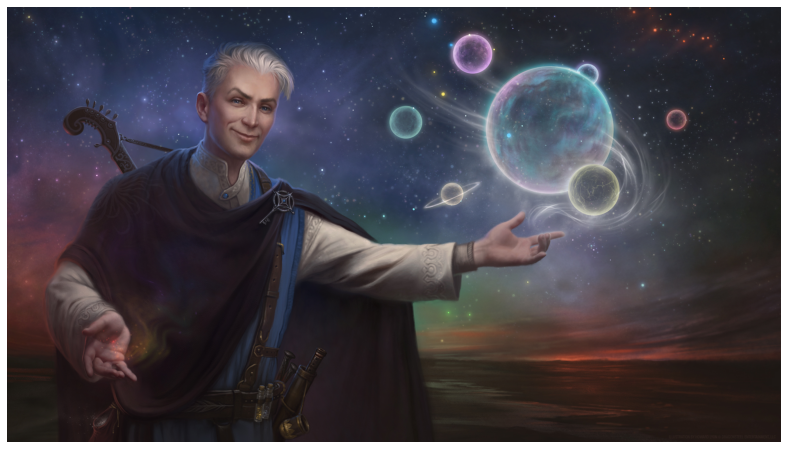

In [94]:
txtStr_to_Image('the_hoid_number')

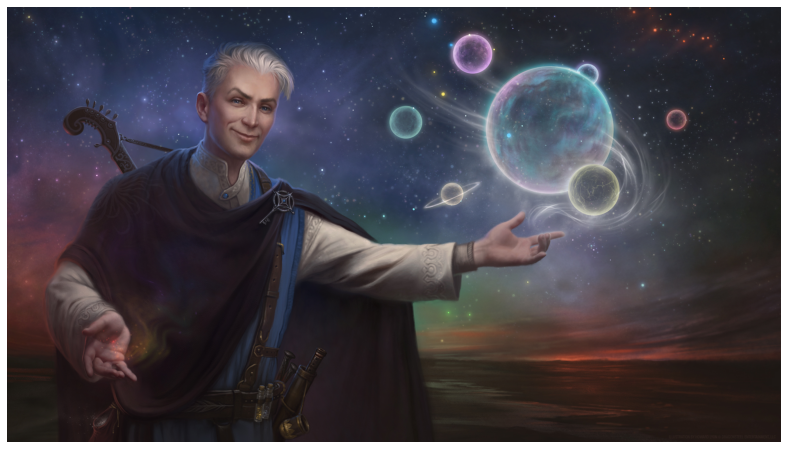

In [5]:
BNR_to_Image('the_hoid_number')